# Genetic Algorithm

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using genetic algorithm.  

As you know there are a lot of variations you can do to do genetic algorithms, but we will assume the following in our implementation given the nature of our problem:

1. Fitness function is used to measure the length of the route.
2. We will be doing real-value GA, so our phenotype is our genotype.
3. We are following generational model for the GA.
4. We are doing 1-point crossover.
5. Mutation for a route is by deleting a gene/node and trying to stitch that gap.
6. Selection is based on fitness-proportionate criteria.

We will explain these assumptions as we go on.

__GENETIC_ALGORITHM__(_source_ , _destination_ , _num of generations_ , _pool size_) __returns__ a route  
&emsp;_pool_ &larr; _pool size_ random-routes between _source_ and _destination_  
&emsp;__for__ _num of generations_ __do__  
&emsp;&emsp; _parents_ &larr; select number of best routes from _pool_  
&emsp;&emsp; _parents_ &larr; crossover _parents_     
&emsp;&emsp; _pool_ &larr; offspring of _parents_ + _parents_  
&emsp;&emsp; _pool_ &larr; mutate _pool_  
&emsp;__endfor__  
&emsp;_route_ &larr; best route in _pool_  
&emsp;__return__ _route_  

In [2]:
import osmnx as ox
import networkx as nx
from IPython.display import IFrame, HTML
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import sys, random
from utilities import *
from itertools import filterfalse

ModuleNotFoundError: No module named 'utilities'

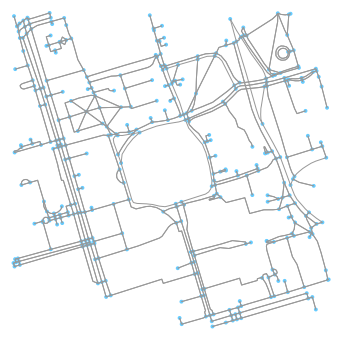

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
fig, ax = ox.plot_graph(G)

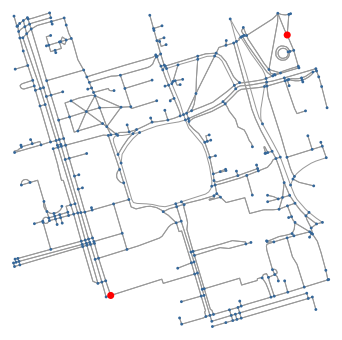

In [3]:
# marking both the source and destination node

nc = ['r' if node == 389677909 or node == 55808290 else '#336699' for node in G.nodes()]
ns = [50 if node == 389677909 or node == 55808290 else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [4]:
%%capture
source(Node)

In [17]:
def random_routes(G, source, destination, nums_of_paths = 1):
    origin = Node(graph = G, node = G[source], osmid = source, distance = 0, parent = None)
    destination = Node(graph = G, node = G[destination], osmid = destination)
    nums = nums_of_paths
    routes = list()
    while nums > 0:
        route = []
        frontier = deque([origin])
        explored = set()
        found = False
        while frontier and not found:
            node = random.choice(frontier)   # here is the randomization part
            frontier.remove(node)
            explored.add(node)
            for child in node.expand():
                if child not in explored and child not in frontier:
                    if child == destination:
                        route, cost = child.path()
                        routes.append((route, cost))
                        found = True
                    frontier.append(child)
        nums -= 1
    return routes

In [18]:
origin = Node(graph = G, node = G[55808290], osmid = 55808290, distance = 0, parent = None)
destination = Node(graph = G, node = G[389677909], osmid = 389677909)

In [19]:
def mutate_path(a, i = 5):
    length = len(a)
    breaking_points = [random.randint(1, length - 2) for _ in range(i)]
    for point in breaking_points:
        i = point - 1
        j = point + 1
        firstNode = a[i]
        secondNode = a[point]
        thirdNode = a[j]
        
        # what we are going to do is to try to go
        # from first node to the third node with either deleting 
        # the second node or choose some other intermediate node
        # between the first and the second
        first_neighbors = list(G[firstNode])
        if thirdNode in first_neighbors:
            a.remove(secondNode)
            breaking_points = [*map(lambda x : x - 1, breaking_points)]
        else:
            for node in first_neighbors:
                if node != secondNode:
                    neighbors = list(G[node])
                    if thirdNode in neighbors:
                        a[point] = node
                        return a
    return a
        

In [20]:
def cross_over(p1, p2):
    intersection = [*filterfalse(lambda element : element in [origin.osmid, destination.osmid] , list(set(p1) & set(p2)))]
    if len(intersection) == 0: return p1
    cross_over_point = random.choice(intersection)
    first_point = p1.index(cross_over_point)
    second_point = p2.index(cross_over_point)
    if probability(0.5):
        return p1[:first_point] + p2[second_point:]
    else:
        return p2[:second_point] + p1[first_point:]

In [21]:
mutate_probability = 0.6
crossover_probability = 0.7
ngen = 50
num_of_population = 50

In [22]:
population = random_routes(G, 55808290, 389677909, nums_of_paths=50)

In [23]:
for generation in range(ngen):
    sorted(population, key = lambda member : member[1])
    numOfmembers = random_even_number(num_of_population)
    members = population[:numOfmembers]
    
    for i in range(numOfmembers):
        mutated_path = mutate_path(members[i][0])
        members[i] = (mutated_path, route_cost(G, mutated_path))
    
    sorted(members, key = lambda member : member[1])
    
    for j in range(numOfmembers - 1):
        crossed_over = cross_over(members[j][0], members[j+1][0])
        members[j] = (crossed_over, route_cost(G, crossed_over))
    population[:numOfmembers] = members

In [24]:
route, cost = min(population, key = lambda member : member[1])

In [25]:
cost

949.236

In [26]:
route

[55808290,
 304891685,
 55808284,
 1721866234,
 389678268,
 4953810915,
 389678267,
 390547782,
 389678107,
 389678111,
 389678112,
 389678145,
 24960070,
 24960073,
 24960076,
 24960080,
 6028561924,
 5098988924,
 730029007,
 2557539842,
 2557539841,
 389678133,
 389677909]

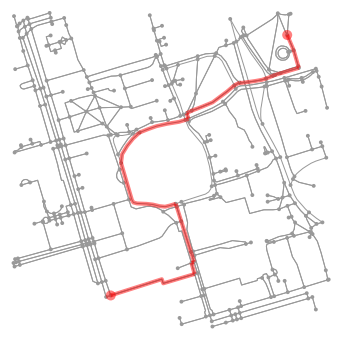

In [27]:
fig, ax = ox.plot_graph_route(G, route)